In [ ]:
# Weights description:
# model_advanced_weights_1.h5 - training with ADAM optimizer on 60% of the dataset without augmentation

In [1104]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from cooltools.lib.numutils import set_diag

from models import simple_1d_cnn
from models import advanced_2d_cnn

In [1105]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [1106]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

In [1107]:
######################### 
# UTIL FUNCTIONS
#########################

In [1108]:
def plot_hic(matrix, use_log_scale = False, chromosome_position = ()):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    
    if len(chromosome_position) != 0:
        ax.set_title(f"{chromosome_position[0]}: {chromosome_position[1][0]}-{chromosome_position[1][1]}", fontsize=25)

In [1109]:
def from_upper_triu(vector_repr, matrix_len = 512, num_diags = 2):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr[0, :, 0]
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [1110]:
######################### 
# Simple 1D CNN Model
#########################

In [1111]:
# TODO

In [1112]:
######################### 
# Advanced 2D CNN Model
#########################

In [1113]:
advanced_model = advanced_2d_cnn.Model().get_model()

In [1114]:
advanced_model.load_weights("./weights/model_advanced_weights_1.h5")

In [8]:
advanced_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 524288, 4)]  0                                            
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 524288, 4)    0           sequence[0][0]                   
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 524288, 96)   4224        re_lu[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 524288, 96)   384         conv1d[0][0]                     
______________________________________________________________________________________________

In [9]:
######################### 
# Predictions
#########################

In [1100]:
test_x = np.load("./train_test_data/test_x.npz")["arr_0"]
test_y = np.load("./train_test_data/test_y.npz")["arr_0"]

In [733]:
# Pick a random region to predict from the test set
regions_to_predict = random.sample(range(0, len(test_x)), 1)

In [852]:
regions_to_predict

[66]

In [1115]:
prediction1 = advanced_model.predict(test_x[regions_to_predict[0], :].reshape(1, 524288, 4))

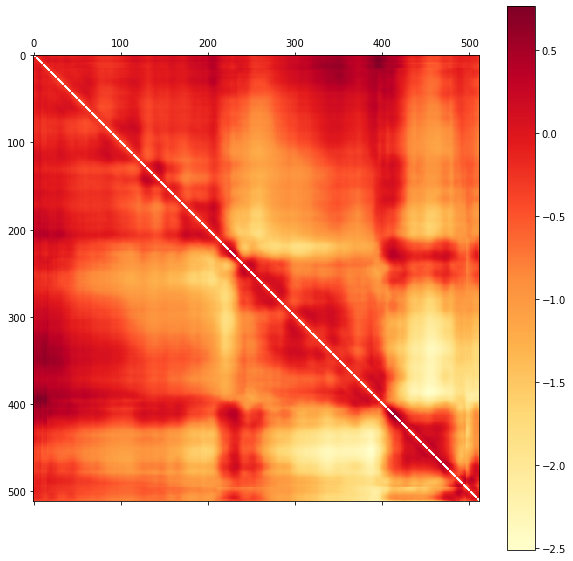

In [1116]:
plot_hic(from_upper_triu(prediction1))

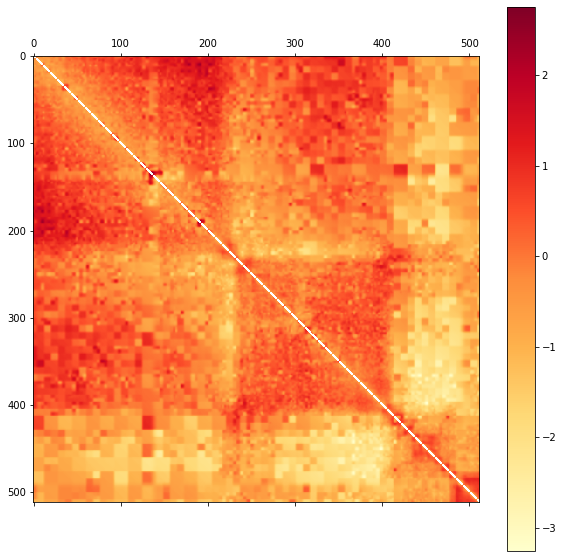

In [775]:
plot_hic(from_upper_triu(test_y[regions_to_predict[0], :].reshape(1, 130305, 1)))

In [ ]:
################################################## 
# GC - content in-silico mutagenesis test
##################################################

# General information:
# median GC% in Drosophila Melanogaster: 42.0751

In [ ]:
# PART 1: Pick a region with the average GC content and try to incrase/decrease GC content

In [1081]:
# Region with average GC content
regions_to_predict = [66]

In [1082]:
prediction1 = advanced_model.predict(test_x[regions_to_predict[0], :].reshape(1, 524288, 4))

In [1083]:
compartment_predicted = from_upper_triu(prediction1)

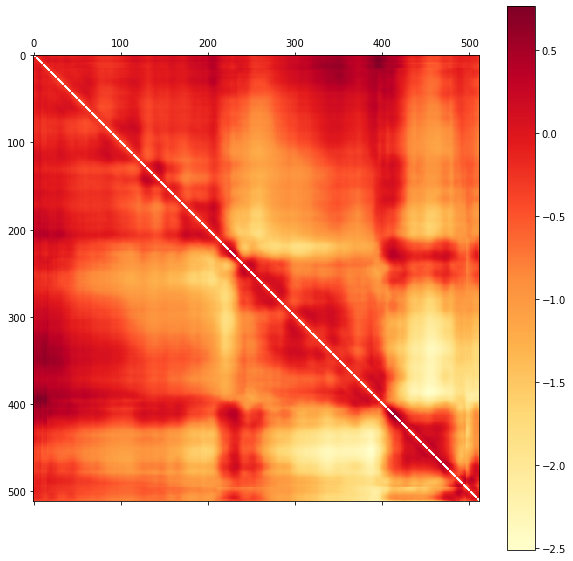

In [1084]:
# untouched sequence prediction
plot_hic(compartment_predicted)

In [943]:
compartment_real = from_upper_triu(test_y[regions_to_predict[0], :].reshape(1, 130305, 1))

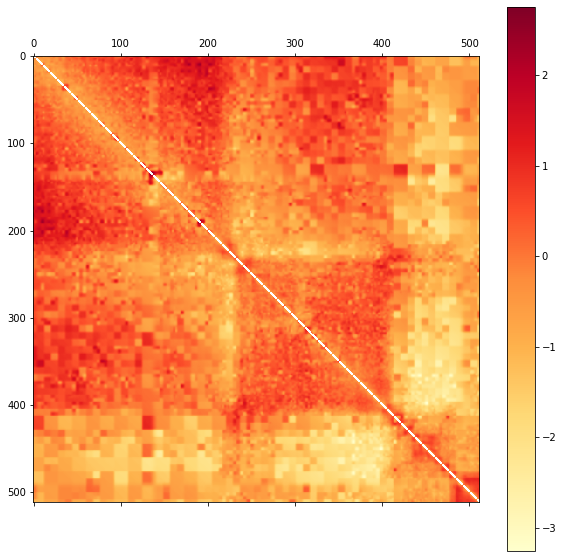

In [1079]:
# untouched sequence real Hi-C
plot_hic(compartment_real)

In [958]:
compartment_seq = np.array(test_x[regions_to_predict[0], :].reshape(1, 524288, 4))

In [984]:
gc_content(compartment_seq) # close to the average GC content of Drosophila Melanogaster

0.41774940490722656

In [1022]:
# increase GC content
increased_gc_seq = np.array(compartment_seq)
increase_gc_content(increased_gc_seq)

In [1023]:
gc_content(increased_gc_seq)

0.6118316650390625

In [1024]:
# predict on increased GC content sequence
increased_prediction = advanced_model.predict(increased_gc_seq)

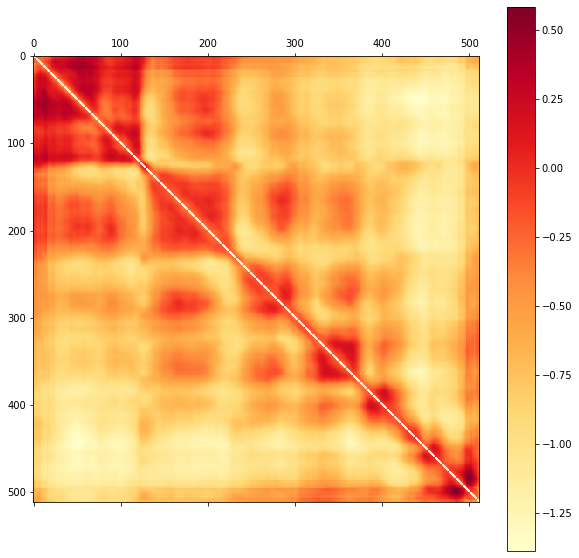

In [1025]:
plot_hic(from_upper_triu(increased_prediction))

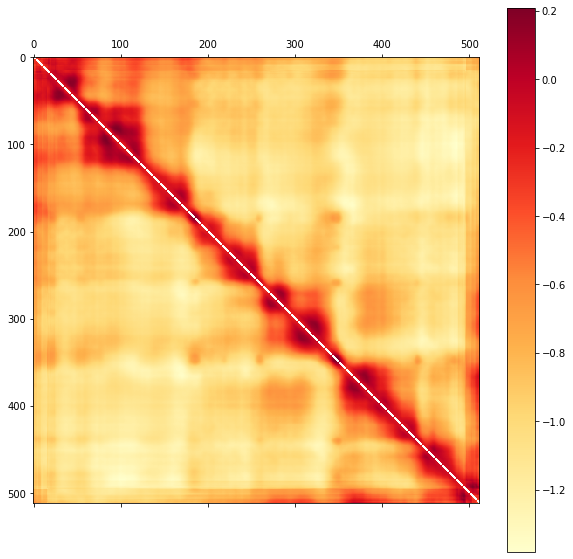

In [1036]:
# Second try

# increase GC content
increased_gc_seq = np.array(compartment_seq)
increase_gc_content(increased_gc_seq)
# predict on increased GC content sequence
increased_prediction = advanced_model.predict(increased_gc_seq)
plot_hic(from_upper_triu(increased_prediction))

In [1075]:
# decrease GC content
decreased_gc_seq = np.array(compartment_seq)
decrease_gc_content(decreased_gc_seq)

In [1076]:
gc_content(decreased_gc_seq)

0.2088756561279297

In [1077]:
# predict on decreased GC content sequence
decreased_prediction = advanced_model.predict(decreased_gc_seq)

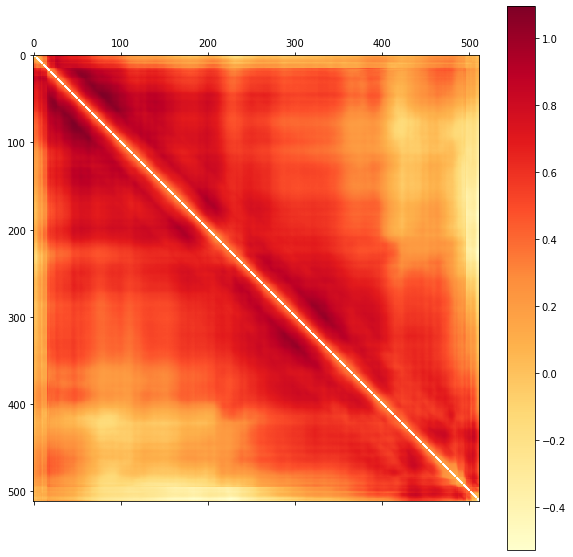

In [1078]:
plot_hic(from_upper_triu(decreased_prediction))

In [ ]:
# one-hot encoding: (A = 0, C = 1, G = 2, T = 3)

In [883]:
def gc_content(seq_one_hot):
    g_count, c_count = np.sum(seq_one_hot[0, :, 2]), np.sum(seq_one_hot[0, :, 1])
    return (g_count + c_count) / seq_one_hot.shape[1]

In [1073]:
def increase_gc_content(seq_one_hot):
    INCREASING_FACTOR = 3 # bigger value -> less increase of g/c content
    
    a_idx = np.array(np.where(seq_one_hot[0, :, 0] == 1))
    t_idx = np.array(np.where(seq_one_hot[0, :, 3] == 1))
    
    a_idx_to_change = a_idx[:, (list(np.random.choice(np.size(a_idx), np.size(a_idx) // INCREASING_FACTOR, replace = False)))]
    t_idx_to_change = t_idx[:, (list(np.random.choice(np.size(t_idx), np.size(t_idx) // INCREASING_FACTOR, replace = False)))]
    
    # replace As
    for i in a_idx_to_change:
        seq_one_hot[0, i, :] = np.array([0., 1., 0., 0.]) if random.uniform(0, 1) >= 0.5 else np.array([0., 0., 1., 0.])
    
    # replace Ts
    for i in t_idx_to_change:
        seq_one_hot[0, i, :] = np.array([0., 1., 0., 0.]) if random.uniform(0, 1) >= 0.5 else np.array([0., 0., 1., 0.])

In [1074]:
def decrease_gc_content(seq_one_hot):
    DECREASING_FACTOR = 2 # bigger value -> less decrease of g/c content
    
    g_idx = np.array(np.where(seq_one_hot[0, :, 2] == 1))
    c_idx = np.array(np.where(seq_one_hot[0, :, 1] == 1))
    
    g_idx_to_change = g_idx[:, (list(np.random.choice(np.size(g_idx), np.size(g_idx) // DECREASING_FACTOR, replace = False)))]
    c_idx_to_change = c_idx[:, (list(np.random.choice(np.size(c_idx), np.size(c_idx) // DECREASING_FACTOR, replace = False)))]
    
    # replace Gs
    for i in g_idx_to_change:
        seq_one_hot[0, i, :] = np.array([1., 0., 0., 0.]) if random.uniform(0, 1) >= 0.5 else np.array([0., 0., 0., 1.])
    
    # replace Cs
    for i in c_idx_to_change:
        seq_one_hot[0, i, :] = np.array([1., 0., 0., 0.]) if random.uniform(0, 1) >= 0.5 else np.array([0., 0., 0., 1.])

In [ ]:
# Можно попробовать GС эксперимент с новой моделью

In [ ]:
# TODO: compare with simple model
# TODO: compare with fine-tuned human model (this model is not trained yet)
# TODO: make a dict containing #index of sampe from the training or test set -> Chr and position in this chrom (this will be useful for illustration purposes)

In [1]:
sq = map(int, input().split()) 


s = 0 
for x in sq: 
    s += x 

print('среднее', s/len(sq))

1 2 3


NameError: name 'n' is not defined

In [2]:
sq = map(int, input().split()) 

1 2 3 4 5


In [3]:
type(sq)

map

In [4]:
sq[2]

TypeError: 'map' object is not subscriptable

In [5]:
sq = list(map(int, input().split()))
for i in sq:
    print(i)

1 2 3 
1
2
3


In [7]:
sq = [int(el) for el in input().split()]

sq[2]

1 2 3 4 


3